In [1]:
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt

In [9]:
results = pd.read_csv('results.csv')[['Round', 'Home', 'Away', 'Score']].set_index(['Home', 'Away'])
fivethirtyeight = pd.read_csv('538.csv').rename(columns={
    'proba': '538_proba',
    'probx': '538_probx',
    'probb': '538_probb',
})
fivethirtyeight['teama'] = fivethirtyeight['teama'].apply(lambda x: x if x != 'USA' else 'United States')
fivethirtyeight['teamb'] = fivethirtyeight['teamb'].apply(lambda x: x if x != 'USA' else 'United States')
fivethirtyeight['teama'] = fivethirtyeight['teama'].apply(lambda x: x if x != 'South Korea' else 'Korea Republic')
fivethirtyeight['teamb'] = fivethirtyeight['teamb'].apply(lambda x: x if x != 'South Korea' else 'Korea Republic')
fivethirtyeight = fivethirtyeight.rename(columns={'teama': 'Home', 'teamb': 'Away'}).set_index(['Home', 'Away'])
m301060 = pd.read_csv('301060.csv')
m301060.columns = ['proba', 'Home', 'probx', 'Away', 'probb']
m301060['proba'] /= 100
m301060['probx'] /= 100
m301060['probb'] /= 100
m301060 = m301060.rename(columns={
    'proba': '301060_proba',
    'probx': '301060_probx',
    'probb': '301060_probb',
}).set_index(['Home', 'Away'])
names = {
    'Qatar': 'qat',
    'Ecuador': 'ecu',
    'England': 'eng',
    'Senegal': 'sen',
    'United States': 'usa',
    'Argentina': 'arg',
    'Denmark': 'den',
    'Mexico': 'mex',
    'France': 'fra',
    'Morocco': 'mor',
    'Germany': 'ger',
    'Spain': 'spa',
    'Belgium': 'bel',
    'Switzerland': 'swi',
    'Uruguay': 'uru',
    'Portugal': 'por',
    'Brazil': 'bra',
    'Wales': 'wal',
    'Netherlands': 'ned',
    'Tunisia': 'tun',
    'Poland': 'pol',
    'Japan': 'jap',
    'Croatia': 'cro',
    'Cameroon': 'cam',
    'Korea Republic': 'kor',
    'Ecuador': 'ecu',
    'Iran': 'ira',
    'Australia': 'aus',
    'Saudi Arabia': 'sau',
    'Canada': 'can',
    'Costa Rica': 'cos',
    'Ghana': 'gha',
    'Serbia': 'ser',
}

def read_oddspedia(f):
    with open(f'oddspedia/{f}.json', 'r') as fp:
        data = json.loads(fp.read())['data']['prematch'][0]['periods'][0]['odds']
    series = {}
    for row in data:
        if row['bookie_slug'] != 'bet365': continue
        p1, p2, p3 = 1/float(row['o1']), 1/float(row['o2']), 1/float(row['o3'])
        series[f'{row["bookie_slug"]}_proba'] = p1/(p1+p2+p3)
        series[f'{row["bookie_slug"]}_probx'] = p2/(p1+p2+p3)
        series[f'{row["bookie_slug"]}_probb'] = p3/(p1+p2+p3)
        series[f'{row["bookie_slug"]}_paya'] = float(row['o1'])
        series[f'{row["bookie_slug"]}_payx'] = float(row['o2'])
        series[f'{row["bookie_slug"]}_payb'] = float(row['o3'])
    return pd.Series(series)

oddspedia = results.apply(lambda row: read_oddspedia(f'{names[row.name[0]]}-{names[row.name[1]]}'), axis=1)
df = results.join(fivethirtyeight).join(m301060).join(oddspedia.dropna(axis=1))
df

,,Round,Score,538_proba,538_probx,538_probb,301060_proba,301060_probx,301060_probb,bet365_proba,bet365_probx,bet365_probb,bet365_paya,bet365_payx,bet365_payb
Home,Away,,,,,,,,,,,,,,
Qatar,Ecuador,Group stage,0–2,0.24,0.26,0.50,0.13,0.21,0.66,0.263158,0.315789,0.421053,3.60,3.00,2.25
England,Iran,Group stage,6–2,0.63,0.25,0.12,0.68,0.20,0.12,0.695688,0.199186,0.105126,1.36,4.75,9.00
Senegal,Netherlands,Group stage,0–2,0.22,0.27,0.51,0.15,0.21,0.64,0.171203,0.261560,0.567238,5.50,3.60,1.66
United States,Wales,Group stage,1–1,0.45,0.29,0.26,0.47,0.29,0.23,0.391244,0.309209,0.299546,2.45,3.10,3.20
Argentina,Saudi Arabia,Group stage,1–2,0.72,0.20,0.08,0.79,0.15,0.05,0.848285,0.110776,0.040939,1.11,8.50,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
England,France,Quarter-finals,1–2,0.52,0.00,0.48,0.37,0.26,0.37,0.344161,0.305304,0.350535,2.75,3.10,2.70
Argentina,Croatia,Semi-finals,3–0,0.64,0.00,0.36,0.57,0.23,0.20,0.490302,0.308416,0.201282,1.95,3.10,4.75
France,Morocco,Semi-finals,2–0,0.66,0.00,0.34,0.44,0.29,0.27,0.615021,0.238321,0.146659,1.55,4.00,6.50


In [10]:
def winner(score):
    if isinstance(score, float) and np.isnan(score):
        return None
    scores = score.split(' ')
    if len(scores) == 1:
        a, b = int(score.split('–')[0]), int(score.split('–')[1])
        if a == b:
            return 'x'
        if a > b:
            return 'a'
        return 'b'
    segs = re.split(r'(\d+)', score)
    if int(segs[1]) < int(segs[7]):
        return 'b'
    return 'a'
df['winner'] = df['Score'].apply(winner)
df

,,Round,Score,538_proba,538_probx,538_probb,301060_proba,301060_probx,301060_probb,bet365_proba,bet365_probx,bet365_probb,bet365_paya,bet365_payx,bet365_payb,winner
Home,Away,,,,,,,,,,,,,,,
Qatar,Ecuador,Group stage,0–2,0.24,0.26,0.50,0.13,0.21,0.66,0.263158,0.315789,0.421053,3.60,3.00,2.25,b
England,Iran,Group stage,6–2,0.63,0.25,0.12,0.68,0.20,0.12,0.695688,0.199186,0.105126,1.36,4.75,9.00,a
Senegal,Netherlands,Group stage,0–2,0.22,0.27,0.51,0.15,0.21,0.64,0.171203,0.261560,0.567238,5.50,3.60,1.66,b
United States,Wales,Group stage,1–1,0.45,0.29,0.26,0.47,0.29,0.23,0.391244,0.309209,0.299546,2.45,3.10,3.20,x
Argentina,Saudi Arabia,Group stage,1–2,0.72,0.20,0.08,0.79,0.15,0.05,0.848285,0.110776,0.040939,1.11,8.50,23.00,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
England,France,Quarter-finals,1–2,0.52,0.00,0.48,0.37,0.26,0.37,0.344161,0.305304,0.350535,2.75,3.10,2.70,b
Argentina,Croatia,Semi-finals,3–0,0.64,0.00,0.36,0.57,0.23,0.20,0.490302,0.308416,0.201282,1.95,3.10,4.75,a
France,Morocco,Semi-finals,2–0,0.66,0.00,0.34,0.44,0.29,0.27,0.615021,0.238321,0.146659,1.55,4.00,6.50,a


In [16]:
def payout_row_301060(row):
    payout = 0.0
    payout -= int(row['301060_proba'] > row['bet365_proba'])
    payout -= int(row['301060_probb'] > row['bet365_probb'])
    payout -= int(row['301060_probx'] > row['bet365_probx'])
    if row['301060_proba'] > row['bet365_proba'] and row['winner'] == 'a':
        payout += row['bet365_paya']
    if row['301060_probb'] > row['bet365_probb'] and row['winner'] == 'b':
        payout += row['bet365_payb']
    if row['301060_probx'] > row['bet365_probx'] and row['winner'] == 'x':
        payout += row['bet365_payx']
    return payout
df['301060_payout'] = df.apply(payout_row_301060, axis=1)
df

,,Round,Score,538_proba,538_probx,538_probb,301060_proba,301060_probx,301060_probb,bet365_proba,bet365_probx,bet365_probb,bet365_paya,bet365_payx,bet365_payb,winner,301060_payout
Home,Away,,,,,,,,,,,,,,,,
Qatar,Ecuador,Group stage,0–2,0.24,0.26,0.50,0.13,0.21,0.66,0.263158,0.315789,0.421053,3.60,3.00,2.25,b,1.25
England,Iran,Group stage,6–2,0.63,0.25,0.12,0.68,0.20,0.12,0.695688,0.199186,0.105126,1.36,4.75,9.00,a,-2.00
Senegal,Netherlands,Group stage,0–2,0.22,0.27,0.51,0.15,0.21,0.64,0.171203,0.261560,0.567238,5.50,3.60,1.66,b,0.66
United States,Wales,Group stage,1–1,0.45,0.29,0.26,0.47,0.29,0.23,0.391244,0.309209,0.299546,2.45,3.10,3.20,x,-1.00
Argentina,Saudi Arabia,Group stage,1–2,0.72,0.20,0.08,0.79,0.15,0.05,0.848285,0.110776,0.040939,1.11,8.50,23.00,b,21.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
England,France,Quarter-finals,1–2,0.52,0.00,0.48,0.37,0.26,0.37,0.344161,0.305304,0.350535,2.75,3.10,2.70,b,0.70
Argentina,Croatia,Semi-finals,3–0,0.64,0.00,0.36,0.57,0.23,0.20,0.490302,0.308416,0.201282,1.95,3.10,4.75,a,0.95
France,Morocco,Semi-finals,2–0,0.66,0.00,0.34,0.44,0.29,0.27,0.615021,0.238321,0.146659,1.55,4.00,6.50,a,-2.00


In [17]:
df['301060_payout'].sum()

52.419000000000004

In [18]:
df.sort_values(by='301060_payout')

,,Round,Score,538_proba,538_probx,538_probb,301060_proba,301060_probx,301060_probb,bet365_proba,bet365_probx,bet365_probb,bet365_paya,bet365_payx,bet365_payb,winner,301060_payout
Home,Away,,,,,,,,,,,,,,,,
Argentina,France,Final,NaN,0.53,0.00,0.47,0.38,0.26,0.37,0.340909,0.318182,0.340909,2.80,3.00,2.80,None,-2.0
Uruguay,Korea Republic,Group stage,0–0,0.53,0.28,0.19,0.58,0.23,0.19,0.536278,0.276025,0.187697,1.75,3.40,5.00,x,-2.0
Croatia,Morocco,Third-place match,NaN,0.53,0.00,0.47,0.28,0.29,0.43,0.404120,0.279319,0.316561,2.35,3.40,3.00,None,-2.0
Iran,United States,Group stage,0–1,0.31,0.31,0.38,0.34,0.28,0.38,0.224930,0.277855,0.497214,4.20,3.40,1.90,b,-2.0
Poland,Saudi Arabia,Group stage,2–0,0.41,0.30,0.29,0.52,0.27,0.20,0.556783,0.262925,0.180292,1.70,3.60,5.25,a,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Germany,Japan,Group stage,1–2,0.60,0.23,0.17,0.46,0.29,0.25,0.662747,0.200917,0.136336,1.44,4.75,7.00,b,5.0
Australia,Denmark,Group stage,1–0,0.20,0.28,0.52,0.21,0.23,0.56,0.135135,0.189189,0.675676,7.00,5.00,1.40,a,5.0
Japan,Costa Rica,Group stage,0–1,0.60,0.25,0.15,0.60,0.24,0.16,0.654362,0.219128,0.126510,1.45,4.33,7.50,b,5.5


In [19]:
def remove_tie(row):
    if row['Round'] != 'Group stage':
        for key, value in row.items():
            if key.endswith('_probx') and value > 0:
                row[key] = 0.0
                row[key[:-1] + 'a'] += value / 2
                row[key[:-1] + 'b'] += value / 2
    return pd.Series(row)
df = df.apply(remove_tie, axis=1)
df

,,Round,Score,538_proba,538_probx,538_probb,301060_proba,301060_probx,301060_probb,bet365_proba,bet365_probx,bet365_probb,bet365_paya,bet365_payx,bet365_payb,winner,301060_payout
Home,Away,,,,,,,,,,,,,,,,
Qatar,Ecuador,Group stage,0–2,0.24,0.26,0.50,0.130,0.21,0.660,0.263158,0.315789,0.421053,3.60,3.00,2.25,b,1.25
England,Iran,Group stage,6–2,0.63,0.25,0.12,0.680,0.20,0.120,0.695688,0.199186,0.105126,1.36,4.75,9.00,a,-2.00
Senegal,Netherlands,Group stage,0–2,0.22,0.27,0.51,0.150,0.21,0.640,0.171203,0.261560,0.567238,5.50,3.60,1.66,b,0.66
United States,Wales,Group stage,1–1,0.45,0.29,0.26,0.470,0.29,0.230,0.391244,0.309209,0.299546,2.45,3.10,3.20,x,-1.00
Argentina,Saudi Arabia,Group stage,1–2,0.72,0.20,0.08,0.790,0.15,0.050,0.848285,0.110776,0.040939,1.11,8.50,23.00,b,21.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
England,France,Quarter-finals,1–2,0.52,0.00,0.48,0.500,0.00,0.500,0.496813,0.000000,0.503187,2.75,3.10,2.70,b,0.70
Argentina,Croatia,Semi-finals,3–0,0.64,0.00,0.36,0.685,0.00,0.315,0.644510,0.000000,0.355490,1.95,3.10,4.75,a,0.95
France,Morocco,Semi-finals,2–0,0.66,0.00,0.34,0.585,0.00,0.415,0.734181,0.000000,0.265819,1.55,4.00,6.50,a,-2.00


In [20]:
def payout_row_538(row):
    payout = 0.0
    payout -= int(row['538_proba'] > row['bet365_proba'])
    payout -= int(row['538_probb'] > row['bet365_probb'])
    payout -= int(row['538_probx'] > row['bet365_probx'])
    if row['538_proba'] > row['bet365_proba'] and row['winner'] == 'a':
        payout += row['bet365_paya']
    if row['538_probb'] > row['bet365_probb'] and row['winner'] == 'b':
        payout += row['bet365_payb']
    if row['538_probx'] > row['bet365_probx'] and row['winner'] == 'x':
        payout += row['bet365_payx']
    return payout
df['538_payout'] = df.apply(payout_row_538, axis=1)
df

,,Round,Score,538_proba,538_probx,538_probb,301060_proba,301060_probx,301060_probb,bet365_proba,bet365_probx,bet365_probb,bet365_paya,bet365_payx,bet365_payb,winner,301060_payout,538_payout
Home,Away,,,,,,,,,,,,,,,,,
Qatar,Ecuador,Group stage,0–2,0.24,0.26,0.50,0.130,0.21,0.660,0.263158,0.315789,0.421053,3.60,3.00,2.25,b,1.25,1.25
England,Iran,Group stage,6–2,0.63,0.25,0.12,0.680,0.20,0.120,0.695688,0.199186,0.105126,1.36,4.75,9.00,a,-2.00,-2.00
Senegal,Netherlands,Group stage,0–2,0.22,0.27,0.51,0.150,0.21,0.640,0.171203,0.261560,0.567238,5.50,3.60,1.66,b,0.66,-2.00
United States,Wales,Group stage,1–1,0.45,0.29,0.26,0.470,0.29,0.230,0.391244,0.309209,0.299546,2.45,3.10,3.20,x,-1.00,-1.00
Argentina,Saudi Arabia,Group stage,1–2,0.72,0.20,0.08,0.790,0.15,0.050,0.848285,0.110776,0.040939,1.11,8.50,23.00,b,21.00,21.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
England,France,Quarter-finals,1–2,0.52,0.00,0.48,0.500,0.00,0.500,0.496813,0.000000,0.503187,2.75,3.10,2.70,b,0.70,-1.00
Argentina,Croatia,Semi-finals,3–0,0.64,0.00,0.36,0.685,0.00,0.315,0.644510,0.000000,0.355490,1.95,3.10,4.75,a,0.95,-1.00
France,Morocco,Semi-finals,2–0,0.66,0.00,0.34,0.585,0.00,0.415,0.734181,0.000000,0.265819,1.55,4.00,6.50,a,-2.00,-1.00


In [21]:
df['538_payout'].sum()

18.030000000000005

In [22]:
df.sort_values(by='538_payout')

,,Round,Score,538_proba,538_probx,538_probb,301060_proba,301060_probx,301060_probb,bet365_proba,bet365_probx,bet365_probb,bet365_paya,bet365_payx,bet365_payb,winner,301060_payout,538_payout
Home,Away,,,,,,,,,,,,,,,,,
Portugal,Uruguay,Group stage,2–0,0.44,0.30,0.26,0.480,0.26,0.260,0.500506,0.288170,0.211325,1.90,3.30,4.500,a,-1.00,-2.0
Korea Republic,Ghana,Group stage,2–3,0.44,0.33,0.23,0.480,0.23,0.290,0.346369,0.307263,0.346369,2.75,3.10,2.750,b,-1.00,-2.0
Wales,England,Group stage,0–3,0.14,0.26,0.60,0.080,0.18,0.750,0.105185,0.218629,0.676187,9.00,4.33,1.400,b,0.40,-2.0
Croatia,Canada,Group stage,4–1,0.41,0.30,0.29,0.660,0.20,0.140,0.428235,0.296471,0.275294,2.25,3.25,3.500,a,1.25,-2.0
Saudi Arabia,Mexico,Group stage,1–2,0.23,0.31,0.46,0.190,0.28,0.530,0.172037,0.225286,0.602677,5.50,4.20,1.570,b,-2.00,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Japan,Spain,Group stage,2–1,0.14,0.25,0.61,0.150,0.21,0.640,0.134831,0.209738,0.655431,7.00,4.50,1.440,a,5.00,5.0
Morocco,Portugal,Quarter-finals,1–0,0.32,0.00,0.68,0.445,0.00,0.545,0.270920,0.000000,0.729080,6.50,3.80,1.571,a,4.50,5.5
Japan,Costa Rica,Group stage,0–1,0.60,0.25,0.15,0.600,0.24,0.160,0.654362,0.219128,0.126510,1.45,4.33,7.500,b,5.50,5.5


In [28]:
payouts = df[['301060_payout', '538_payout']].reset_index()
payouts['match'] = payouts.apply(lambda row: f'{row["Home"]}-{row["Away"]}', axis=1)
payouts = payouts.drop(['Home', 'Away'], axis=1)
payouts

,301060_payout,538_payout,match
0,1.25,1.25,Qatar-Ecuador
1,-2.00,-2.00,England-Iran
2,0.66,-2.00,Senegal-Netherlands
3,-1.00,-1.00,United States-Wales
4,21.00,21.00,Argentina-Saudi Arabia
...,...,...,...
59,0.70,-1.00,England-France
60,0.95,-1.00,Argentina-Croatia
61,-2.00,-1.00,France-Morocco
62,-2.00,-1.00,Croatia-Morocco


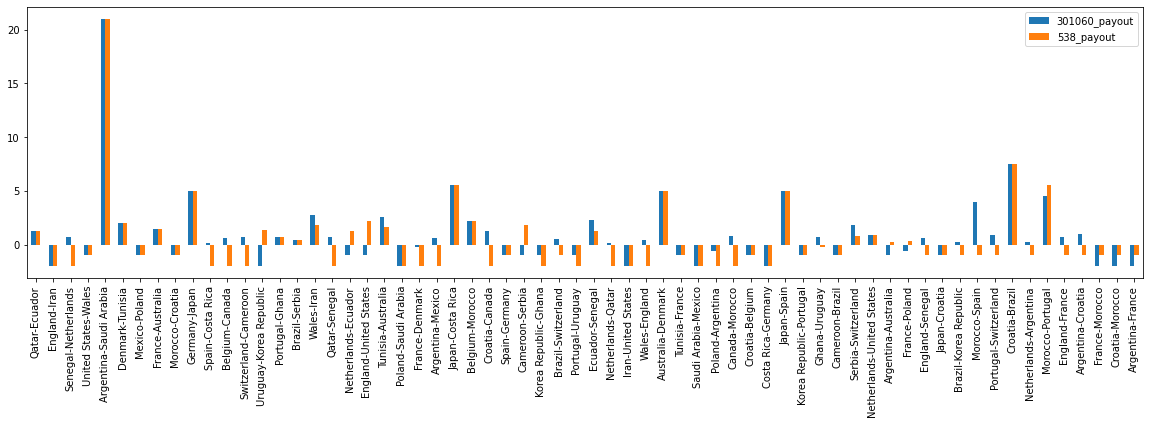

In [40]:
_, ax = plt.subplots(figsize=(20, 5))
payouts.plot.bar(ax=ax)
ax.set_xticklabels(payouts['match']);